#Algoritmo Naive Bayes Multinomial Classifier

##Importación de dependencias y carga de los datos

In [ ]:
import numpy as np
import pandas as pd
import re
import plotly.express as px

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
lemmatizer = WordNetLemmatizer()

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Cargar los datos desde el csv a un dataframe de pandas
reviews = pd.read_csv('/content/tipo2_entrenamiento_estudiantes.csv', encoding = 'utf-8')

##Entendimiento y preparacion de los datos

En este punto haremos un analisis visual y estadistico del los datos en su forma original. Es decir, veremos con que tipos de datos vamos a trabajar, como enteros o cadenas; cuales son sus dimensiones; buscaremos datos que se encuentren repetidos y tambien datos que no sean consistentes o que representen un obstaculo para el trabajo llevado a cabo por el algoritmo.

Posterior a esto, pasaremos a realizar modificaciones a nuestros datos que nos sirvan para generar mejores resultados. Estas transformaciones se iran explicando a medida que se van aplicando.

### Vista de la forma original de los datos

In [ ]:
reviews.head()

,Review,Class
0,Muy buena atención y aclaración de dudas por p...,5
1,Buen hotel si están obligados a estar cerca de...,3
2,"Es un lugar muy lindo para fotografías, visite...",5
3,Abusados con la factura de alimentos siempre s...,3
4,Tuvimos un par de personas en el grupo que rea...,3


Como se observa nuestro data frame esta conformado unicamente por dos columnas: una para le reseña y otra para la clase a la que pertenece. Dado que no se tiene mas información al respecto, asumiremos que esta clase hace las veces de una calificación que hace el turista sobre su experiencia en el hotel.

### Revisión de la dimensión e integridad de los datos

In [ ]:
reviews.info()

print("\nDimensión de los datos: ",reviews.shape)

print("\nRevisión de valores nulos: " )
print(reviews.isnull().sum())

print("\nRevisión de valores repetidos: ", reviews.duplicated().sum())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7875 entries, 0 to 7874
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  7875 non-null   object
 1   Class   7875 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 123.2+ KB

Dimensión de los datos:  (7875, 2)

Revisión de valores nulos: 
Review    0
Class     0
dtype: int64

Revisión de valores repetidos:  73


In [ ]:
reviews.drop_duplicates()


,Review,Class
0,Muy buena atención y aclaración de dudas por p...,5
1,Buen hotel si están obligados a estar cerca de...,3
2,"Es un lugar muy lindo para fotografías, visite...",5
3,Abusados con la factura de alimentos siempre s...,3
4,Tuvimos un par de personas en el grupo que rea...,3
...,...,...
7870,"Me parece buen sistema, agiliza el transporte,...",4
7871,"Fue una escapada de un día desde el complejo, ...",4
7872,La Plaza de la Revolución es un lugar emblemát...,3
7873,Es la segunda ocasión que me quedo en los cuar...,1


Como se observa, nuestro data frame consta de 7875 reseñas, todos los valores son consistentes y validos, sin embargo, hay presencia de reseñas repertidas. Esto ultimo puede representar un inconveniente a pesar de que se trata de muy pocos valores repetidos dado que el modelo durante su entrenamiento puede llegar a pensar que las palabras que contienen las reseñas repetidas tienen mas valor o significancia por encima del resto dado que su presencia es mayor gracias a los duplicados. Por este motivo procedemos a retirarlas para un total de 1802 tuplas.

### Revisión de variables categoricas

En este punto, procederemos a revisar en que magnitud hacen presencia las diferentes clase dentro del data frame. Para lograr un mejor entendimiento de esto transformaremos, de manera temporal, las clases por nombres algo mas dicientes.

In [ ]:
reviews['Class'] = reviews['Class'].replace({
    1: 'Muy Negativo',
    2: 'Negativo',
    3: 'Neutro',
    4: 'Positivo',
    5: 'Muy Positivo'
})

Una vez hecho este cambio, temporal, vamos a ver cuantos datos hay de cada clase.

In [ ]:
print("Conteo de clases: \n",reviews.Class.value_counts())


Conteo de clases: 
 Class
Muy Positivo    2361
Positivo        1977
Neutro          1574
Negativo        1185
Muy Negativo     778
Name: count, dtype: int64


In [ ]:
fig=px.histogram(reviews,
                x='Class',
                title='Conteo de clases ',
                color_discrete_sequence=['green'])
fig.update_layout(bargap=0.1)
fig.show()
fig = px.pie(reviews, names='Class',title="Proporción de clases")
fig.show()


De las enteriores visualizaciones podemos inferir que las reseñas positivas dominan por encia de las neutras y de las negativas. Ademas, las reseñas muy negativas ocupan un proporción pequeña lo cual nos puede indicar que las palabras presentes en reseñas negativas pueden determinantes a la hora de reconocer una de estas.

### Analisis de la longitud de las reseñas

En este punto revisaremos algunas estadisticas importantes sobre la longitud de las reseñas. Esto es importante por cuanto la longitud de una reseña puede dar pistas si esta es negativa, positiva o neutra. Por ejemplo, las personas con sentiemientos neutros sobre su experiencia puede que dejen reseñas cortas y directas. Por otro lado, personas con gran insatisfacción pueden dejar reseñas bastante descriptivas.

Para lograr lo anterior, añadiremos una nueva columna a nuestro data frame sobre la longitud de la reseña y asi poder sacar algunas estadisticas de la misma. Como se vera, la columna lleva el nombre de 'OrginalLenght' dado que mas adelante se deberan hacer transformaciones sobre las reseñas que van a alterar su longitud.

In [ ]:
def text_length(tweet):
    str_len=len(tweet.split(" "))
    return(str_len)
reviews['OriginalLength']= reviews['Review'].apply(lambda x:text_length(x))
reviews.head()

,Review,Class,OriginalLength
0,Muy buena atención y aclaración de dudas por p...,Muy Positivo,40
1,Buen hotel si están obligados a estar cerca de...,Neutro,54
2,"Es un lugar muy lindo para fotografías, visite...",Muy Positivo,17
3,Abusados con la factura de alimentos siempre s...,Neutro,81
4,Tuvimos un par de personas en el grupo que rea...,Neutro,70


In [ ]:
reviews['OriginalLength'].describe()

count    7875.000000
mean       71.028190
std        81.745547
min         2.000000
25%        34.000000
50%        46.000000
75%        86.000000
max      1793.000000
Name: OriginalLength, dtype: float64

In [ ]:
fig = px.histogram(reviews,
                  x='OriginalLength',
                  marginal='box',
                  title="Longitud de las reseñas originales")
fig.update_layout(bargap=0.1)
fig.show()

De lo anterior podemos inferir de que la longitud de los datos siga al parecido a una distribucón normal y que existen muchos outliers o reseñas cuya longitud se aleja bastante del promedio. Veamoslo ahora por la clase involucrada.

In [ ]:
reviews.groupby('Class')['OriginalLength'].agg(['mean','max','min'])


,mean,max,min
Class,,,
Muy Negativo,87.602828,887,9
Muy Positivo,57.496400,1793,8
Negativo,87.439662,1321,9
Neutro,78.747141,1467,4
Positivo,64.683359,1021,2


Como se nota el dominio de los negativo tiene el promedio mas alto de longitud lo cual es entendible dado que pueden ser mas descriptivas. Sin embargo, las reseñas mas cortas resultaron ser las muy positivas y no las neutras como lo habiamos inferido.

### Limpieza de las reseñas

Una vez hemos entendido las dimensión y comportamiento de las reseñas y sus clasificaciones es necesario que entremos a limpiar las reseñas de toda clase de palabras que son gramaticalmente impresindibles pero que no agregan mayor signigicancia a la misma. Esto se conoce como 'stopwords' o palabras vacias. Adicional esto tambien limpieramos nuestras reseñas de 'fillerwords' que son palabras que en el discurso oral usariamos como muletillas pero que muchas persona inapropiadamente tambien las usan en su discurso escrito.

Adicional esto, tambien buscaremos eliminar todo tipo de caracteres especial o informacíon que no se puede analizar directamente mediante tecnicas de analisis de texto tales como links.

Por ultimo, se usa la funcion 'lemmatizer' para dejar las palabras en su forma base o infinitiva, por ejemplo, la palabra 'felicitaciones' se deja en la forma 'felicitar'. Esto se hace con el fin de que el modelo no tome como diferentes palabras con el mismo significado pero con diferente conjugación.

In [ ]:
import string

def data_cleaning(data):
    cleaned_data = []
    fillerWord =  ("Eh","Mmm","Pues","Bueno","Este","Como","Entonces","O sea","Tipo","¿Sabes?","En fin","¿Entiendes?","Vale","La cosa es que", "¿Verdad?")
    fillerword_reg= r"\b(Eh|Mmm|Pues|Bueno|Este|Como|Entonces|O\s+sea|Tipo|¿Sabes?|En\s+fin|¿Entiendes?|Vale|La\s+cosa\s+es\s+que|¿Verdad?)\b"
    STOPWORDS = set(stopwords.words('spanish'))
    remove = ["no", "ni", "tampoco", "jamás", "nunca", "nadie", "ninguno", "ningún", "nada"]
    for i in remove:
        STOPWORDS.discard(i)

    STOPWORDS.add(fillerWord)
    for i in range(len(data)):
        rev = re.sub("#", "", data[i])#extracting hashtags
        rev = re.sub(r'^https?:\/\/.*[\r\n]*', '',rev, flags=re.MULTILINE)#extracting links
        html=re.compile(r'<.*?>')#extracting html tags
        rev =html.sub(r"", rev)
        #extracting symbols and characters
        rev=re.sub(r'@\w+',"",rev)
        rev=re.sub(r'#\w+',"",rev)
        rev=re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', rev)
        punctuation = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""
        rev.rstrip(string.punctuation)
        rev=re.sub('[^A-Za-z\s]+',"", rev)
        rev = rev.lower()
        rev = rev.split()

        #Lemmatization to normalise text
        rev = [lemmatizer.lemmatize(word) for word in rev if not word in STOPWORDS]
        rev = ' '.join(rev)
        filler=re.compile(fillerword_reg)
        rev=filler.sub("",rev)
        cleaned_data.append(rev)
    return cleaned_data

In [ ]:

text_data = reviews['Review'].tolist()

process_text = data_cleaning(text_data)

cleaned_rev = pd.DataFrame(process_text)

reviews['CleanedReview'] = cleaned_rev

reviews.head()

,Review,Class,OriginalLength,CleanedReview
0,Muy buena atención y aclaración de dudas por p...,Muy Positivo,40,buena atencin aclaracin dudas parte seorita ve...
1,Buen hotel si están obligados a estar cerca de...,Neutro,54,buen hotel si estn obligados cerca centro conv...
2,"Es un lugar muy lindo para fotografías, visite...",Muy Positivo,17,lugar lindo fotografas visiten selina msica vi...
3,Abusados con la factura de alimentos siempre s...,Neutro,81,abusados factura alimentos siempre echan culpa...
4,Tuvimos un par de personas en el grupo que rea...,Neutro,70,par persona grupo realmente queramos comer cab...


Ahora que hemos depurado las reseñas veamos en cuanton cambio la extensión de las mismas.

In [ ]:
reviews['NewLength']= reviews['CleanedReview'].apply(lambda x:text_length(x))

reviews['NewLength']= reviews['CleanedReview'].apply(lambda x:text_length(x))

reviews.head()

,Review,Class,OriginalLength,CleanedReview,NewLength
0,Muy buena atención y aclaración de dudas por p...,Muy Positivo,40,buena atencin aclaracin dudas parte seorita ve...,23
1,Buen hotel si están obligados a estar cerca de...,Neutro,54,buen hotel si estn obligados cerca centro conv...,30
2,"Es un lugar muy lindo para fotografías, visite...",Muy Positivo,17,lugar lindo fotografas visiten selina msica vi...,11
3,Abusados con la factura de alimentos siempre s...,Neutro,81,abusados factura alimentos siempre echan culpa...,42
4,Tuvimos un par de personas en el grupo que rea...,Neutro,70,par persona grupo realmente queramos comer cab...,37


In [ ]:
print(reviews.NewLength.describe())

fig = px.histogram(reviews,
                  x='NewLength',
                  marginal='box',
                  title="Longitud de las reseñas limpias",
                  color_discrete_sequence=['blue'])
fig.update_layout(bargap=0.1)

fig.show()

count    7875.000000
mean       37.073016
std        42.597753
min         1.000000
25%        18.000000
50%        25.000000
75%        45.000000
max       956.000000
Name: NewLength, dtype: float64


De lo anterior podemos notar que hay una disminución importante en la longitud de las palabras, sin embargo, la presencia de outliers sigue siendo importante.

### División de los datos en entrenamiento y prueba

En esta sección deberemos de separar nuestros datos para poder entrenar al modelo.

In [ ]:
X_train = reviews.CleanedReview
Y_train = reviews.Class

Debemos de separar los datos de prueba en dos grupos, uno que contiene las reseñas depuradas y otro que contiene la clasificación respectiva de la reseña. Esto se debe hacer dado que el algoritmo necesita estos parametros por separado.

### Codificación de las etiquetas de las reseñas

Dado anteriormente habiamos cambiado el formato de Class de numerico a categorico con el fin de entender mejor los datos, ahora, debemos reversar ese procedimiento a traves de laber encoder dado que nuestro algoritmo solo puede trabajar con datos númericos y vectoriales.

In [ ]:
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)

In [ ]:
Y_train = pd.DataFrame(Y_train,columns=['Class'])
Y_train.head()

,Class
0,1
1,3
2,1
3,3
4,3


In [ ]:
Y_train['Class'].unique()

array([1, 3, 4, 2, 0])

## Modelado y evalución

En este aprate llevaremos a cabo todos los procedimientos relativos a la creación de parametros de nuestor modelo y el entrenamiento y evaluación del mismo.

### Inicializar bags of words

El "Bag of Words" (BoW) es una técnica de procesamiento de lenguaje natural que representa documentos como vectores de frecuencia de palabras, ignorando el orden y la gramática. Se tokenizan los documentos, se construye un vocabulario único y se cuenta la frecuencia de cada palabra en cada documento. Esto permite realizar análisis estadísticos y aplicar algoritmos de aprendizaje automático en tareas como clasificación de documentos y análisis de sentimientos, aunque no captura la estructura gramatical o el significado contextual de las palabras.

In [ ]:
vectorizer = CountVectorizer(max_features= 3000, min_df = 3, max_df = 0.6)
# fit the model for training data
X_train_data = vectorizer.fit_transform(X_train)

In [ ]:
X_train_data.shape

(7875, 3000)

In [ ]:
Y_train.shape

(7875, 1)

### Inicialización de Tfid

El TF-IDF (Term Frequency-Inverse Document Frequency) Transformer es una técnica en el procesamiento de lenguaje natural que convierte datos de texto en representaciones numéricas más útiles para el análisis. Evalúa la importancia de una palabra en un documento basándose en dos factores: la frecuencia de la palabra en el documento y la rareza de la palabra en el conjunto de documentos. Asigna pesos numéricos a cada palabra, reflejando su relevancia tanto en el documento específico como en el corpus completo. Esta transformación permite representar documentos como vectores numéricos que pueden utilizarse en algoritmos de aprendizaje automático para diversas tareas de NLP, como clasificación de texto y recuperación de información.

In [ ]:
transformer = TfidfTransformer()
X_train_data = transformer.fit_transform(X_train_data).toarray()


## Entrenamiento del modelo

Para entrenar el modelo se utilizar dos tecnicas para el paso de parametros: 'train_test_slipt' e 'HyperParameter Tuning'. Ambos se explicaran respectivamente.

### Train-test slipt

La función `train_test_split` es una herramienta fundamental en el aprendizaje automático que divide un conjunto de datos en dos subconjuntos: uno para entrenar el modelo y otro para evaluar su rendimiento. Esto se realiza asignando aleatoriamente una proporción de los datos al conjunto de entrenamiento y el resto al conjunto de prueba. El conjunto de entrenamiento se utiliza para ajustar los parámetros del modelo, mientras que el conjunto de prueba se emplea para evaluar su rendimiento en datos no vistos. Esta división es crucial para evitar el sobreajuste del modelo, es decir, que el modelo se ajuste demasiado bien a los datos de entrenamiento pero no pueda generalizar adecuadamente a nuevos datos. Al proporcionar una evaluación independiente del rendimiento del modelo, `train_test_split` ayuda a estimar la capacidad de generalización del modelo y a seleccionar el mejor entre diferentes configuraciones o algoritmos.

In [ ]:

from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X_train_data, Y_train, test_size=0.33,random_state = 15)

In [ ]:
model1_nb = MultinomialNB()
y_train_pred = model1_nb.fit(X1_train,y1_train.Class).predict(X1_train)

y_pred = model1_nb.predict(X1_test)

# comparing actual response values  with predicted response values
from sklearn import metrics
print("Multinomial Naive Bayes model train accuracy(in %):", metrics.accuracy_score(y1_train, y_train_pred)*100)
print("Multinomial Naive Bayes model test accuracy(in %):", metrics.accuracy_score(y1_test, y_pred)*100)

Multinomial Naive Bayes model train accuracy(in %): 66.73616376042456
Multinomial Naive Bayes model test accuracy(in %): 46.36398614851866


### HyperParameter Tuning

La optimización de hiperparámetros, o "Hyperparameter Tuning" en inglés, es un proceso esencial en el aprendizaje automático que implica encontrar la mejor combinación de valores para los hiperparámetros de un modelo con el fin de mejorar su rendimiento predictivo. Los hiperparámetros son configuraciones que no se aprenden automáticamente durante el entrenamiento del modelo y que afectan la capacidad del modelo para ajustarse a los datos y generalizar a nuevos ejemplos. Algunos ejemplos comunes de hiperparámetros incluyen la tasa de aprendizaje en algoritmos de aprendizaje profundo, la profundidad máxima de un árbol de decisión y el valor de regularización en modelos de regresión. La optimización de hiperparámetros se realiza mediante técnicas como búsqueda grid, búsqueda aleatoria o métodos más avanzados como la optimización bayesiana. El objetivo final es encontrar la combinación óptima de hiperparámetros que maximice el rendimiento del modelo en un conjunto de datos de validación independiente. Esto ayuda a mejorar la precisión y la capacidad de generalización del modelo, lo que resulta en mejores resultados en problemas de aprendizaje automático.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {'alpha': [0.01,0.1,0.5,1,10],
         }

multinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
multinomial_nb_grid.fit(X_train_data,Y_train)

print('Train Accuracy : %.3f'%multinomial_nb_grid.best_estimator_.score(X1_train, y1_train))
print('Test Accuracy : %.3f'%multinomial_nb_grid.best_estimator_.score(X1_test, y1_test))
print('Best Accuracy Through Grid Search : %.3f'%multinomial_nb_grid.best_score_)
print('Best Parameters : ',multinomial_nb_grid.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Train Accuracy : 0.669
Test Accuracy : 0.662
Best Accuracy Through Grid Search : 0.469
Best Parameters :  {'alpha': 0.5}


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



### Evalución del modelo

Ahora que hemos refinado y entrenado nuestro modelo pasemos a evaluarlo de manera cuantitavia y cualitiva.

### Cuantitativa

Como lo podremos observar, nuestor modelo presenta cierta afinidad hacia las reseñas positivas en general respecto del resto. Esto quiere decir que tiene a clasificar de manera demas acertada las reseñas postivas y muy positvas, sin embargo, llega un punto en el que no distingue demasiado bien entre una reseña muy positiva y otra simplemente positiva.

De otro lado, las reseñas negativas tambien presentar un desempeño descente a pesar de tener varios desaciertos en especial al clasificar como nuetras.

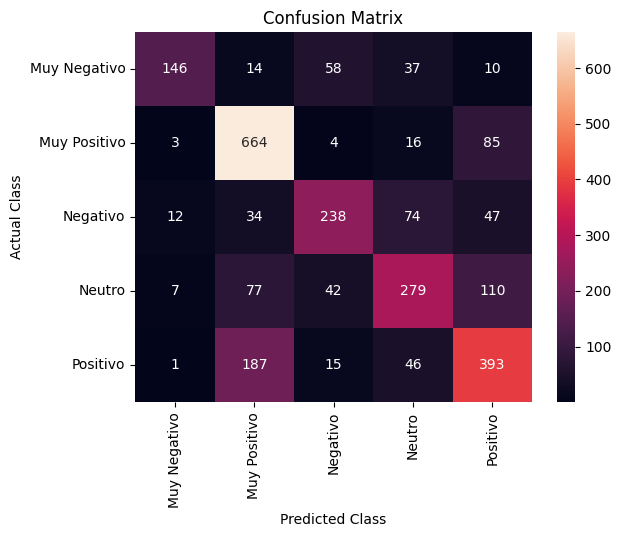

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the predicted labels for the test data
y_pred = multinomial_nb_grid.predict(X1_test)

# Calculate the confusion matrix
cm = confusion_matrix(y1_test, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_)

# Set the title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

# Show the plot
plt.show()


### Cualitativa

Ahora veamos algunas cifras que nos deja nuestro modelo:

Precision: La precisión es la proporción de predicciones positivas que fueron correctas en relación con el total de predicciones positivas realizadas por el modelo. En este caso, las precisiones van desde un 61% para la clase "Positivo" hasta un 86% para la clase "Muy Negativo". Esto indica la capacidad del modelo para identificar correctamente cada clase.

Recall: El recall, también conocido como sensibilidad, es la proporción de instancias positivas que fueron correctamente identificadas por el modelo en relación con el total de instancias positivas en los datos de prueba. Las tasas de recall oscilan entre un 54% para la clase "Neutro" y un 86% para la clase "Muy Positivo". Esto indica la capacidad del modelo para capturar correctamente todas las instancias de cada clase.

F1-score: El F1-score es la media armónica de la precisión y el recall, proporcionando una métrica única que combina ambos aspectos de la evaluación del modelo. Varía entre 0 y 1, donde 1 representa la mejor puntuación posible. Los valores de F1-score oscilan entre 0.58 para la clase "Neutro" y 0.76 para la clase "Muy Positivo".

Support: La cantidad de muestras de cada clase en el conjunto de datos de prueba.

Accuracy: La precisión global del modelo, que es la proporción de predicciones correctas respecto al total de predicciones realizadas. En este caso, la precisión global es del 66%.

Macro avg y Weighted avg: La media de las métricas de precision, recall y F1-score, calculadas para cada clase, ponderadas o no ponderadas según el soporte de cada clase.


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y1_test, y_pred, target_names=encoder.classes_))


              precision    recall  f1-score   support

Muy Negativo       0.86      0.55      0.67       265
Muy Positivo       0.68      0.86      0.76       772
    Negativo       0.67      0.59      0.62       405
      Neutro       0.62      0.54      0.58       515
    Positivo       0.61      0.61      0.61       642

    accuracy                           0.66      2599
   macro avg       0.69      0.63      0.65      2599
weighted avg       0.67      0.66      0.66      2599



Como se puede notar nuestro modelo es especialmente bueno para clasificar reseñas muy negativas, lo cual, puede derivar de la alta significancia de palabras con una connotación negativa. Estas palabras son mas contundentes a la hora de señalar la instasfacción dado que su significado es obasolutamente negativo, por ejemplo, nadie se puede alegrar de ver una 'cucaracha' en su cuarto o de ser 'robado' en la playa.  

Por otro lado, las reseñas neutras significaron un gran desafio para el modelo dado el lenguaje plano y inexpresivo que pueden llegar a caracterizar estas reseñas.

### Palabras significantes

In [ ]:
log_probabilities = model1_nb.feature_log_prob_[1]  # Probabilidades condicionales de la clase 1
feature_names = vectorizer.get_feature_names_out()

In [ ]:
log_probabilities_words = list(zip(feature_names, log_probabilities))


In [ ]:
log_probabilities_words_sorted = sorted(log_probabilities_words, key=lambda x: x[1], reverse=True)


In [ ]:
num_palabras_a_mostrar = 10
palabras_con_mayores_coeficientes = log_probabilities_words_sorted[:num_palabras_a_mostrar]

In [ ]:
for palabra, log_probabilidad in palabras_con_mayores_coeficientes:
    print(f"Palabra: {palabra}, Log Probabilidad: {log_probabilidad}")

Palabra: excelente, Log Probabilidad: -4.9165830683905805
Palabra: lugar, Log Probabilidad: -5.154366127747604
Palabra: comida, Log Probabilidad: -5.158048770337519
Palabra: servicio, Log Probabilidad: -5.226131819226985
Palabra: no, Log Probabilidad: -5.45541024525458
Palabra: atencin, Log Probabilidad: -5.522766254280668
Palabra: buena, Log Probabilidad: -5.57165546888745
Palabra: hotel, Log Probabilidad: -5.676358752877768
Palabra: bien, Log Probabilidad: -5.685103598448263
Palabra: ciudad, Log Probabilidad: -5.706961770383256


Como se puede observar las palabras relacionadas con el lugar, la comida, el servicio, la atención y el hotel, entre otras resultaron ser determinantes para la clasificación de la reseña.

## Resultados

En este punto se guarda el modelo entrenado y se predice sobre el conjunto de datos de partición prueba estudiantes.

In [ ]:
import pickle

In [ ]:
filename = 'trained_model.csv'
pickle.dump(model1_nb, open(filename, 'wb'))

In [ ]:
# loading the saved model
loaded_model = pickle.load(open('/content/trained_model.csv', 'rb'))

In [ ]:

reviews_prueba = pd.read_csv('particion_prueba_estudiantes.csv')
reviews_prueba['CleanedReview'] = data_cleaning(reviews_prueba['Review'].tolist())
X_test = reviews_prueba.CleanedReview
X_test_data = vectorizer.transform(X_test)
X_test_data = transformer.transform(X_test_data).toarray()
y_pred = loaded_model.predict(X_test_data)
reviews_prueba['Class'] = y_pred
reviews_prueba.drop(columns=['CleanedReview'], inplace=True)
reviews_prueba['Class'] = reviews_prueba['Class'] + 1
reviews_prueba.to_csv('resultados.csv', index=False)